In [8]:
import pandas as pd
import numpy as np
from experiment_utils import *
import matplotlib.pyplot as plt
import os

# Set the parameters of the experiments and the number of iterations to run each experiment.

# parameters used in experiments
parameters = [
    (b, val, mode) 
    for val in (0.05, 0.1, 0.25, 0.5, 0.75, 1.0) 
    for mode in ('additive', 'multiplicative') 
    for b in (True, False)
]

# parameters used for debugging
parameters = [(True, 1.0, 'additive')]

num_iterations = 1


## Run State, County, and SNAP Experiments
#### The results will be saved to a csv in the results folder, which also contains results from previous experiments.

In [78]:
suggest_r = 6

time_period = 'Year'
outcome = 'Below Poverty Level'
covariates = ['Total Population', 'White Alone', 'Black or African American Alone', 
              'Median Household Income', 'Median Housing Value', 'Median Age', 'Total Employment', 
              'Below Poverty Level', 'Housing Units', 'Year']
covariates.remove(outcome)
effect_direction = 'negative'

df_orig = pd.read_csv('raw_data/census_data.csv')
unit='State Name' 


run_experiment(df_orig, unit, time_period, outcome, covariates, effect_direction, parameters, num_iterations, suggest_r) # run state experiment

df_orig = pd.read_csv('raw_data/census_county_data.csv')
unit='County Name'


run_experiment(df_orig, unit, time_period, outcome, covariates, effect_direction, parameters, num_iterations, suggest_r) # run county experiment

df_orig = pd.read_csv('raw_data/SNAP_Users_data.csv')
unit = 'CLIENT_ZIP'
time_period = 'YearMonth'
outcome = 'OUTCOME'
covariates = ["Male_Population", "Female_Population", "Median_Age", "Total_Population", 
                "Race_White", "Unemployed", "Education_25_Over", "Total_Pop_Below_Poverty", "Year", "Month"]   
effect_direction = 'positive'

run_experiment(df_orig, unit, time_period, outcome, covariates, effect_direction, parameters, num_iterations, suggest_r) # run SNAP experiment



The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Results saved to results/results_20241009_211736.csv


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Results saved to results/results_20241009_212618.csv


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Results saved to results/results_20241009_213629.csv


## Analyze the accuracy of the ATE and ATT estimates 

In [9]:
import pandas as pd
import os

# Path to your folder containing the CSV files
folder_path = 'results'

# Initialize an empty dataframe to hold all the data
combined_df = pd.DataFrame()

# Loop through each CSV file in the folder and concatenate the data
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

# Filter the dataframe to include rows where Method is either 'PaCE_1', 'PaCE_40', or does not start with 'PaCE'
filtered_df = combined_df[(combined_df['Method'].isin(['PaCE_1', 'PaCE_40'])) | (~combined_df['Method'].str.startswith('PaCE'))]

# Calculate absolute percentage difference for ATE
filtered_df['ATE_abs_perc_diff'] = abs((filtered_df['Estimated ATE'] - filtered_df['True ATE']) / filtered_df['True ATE']) * 100

# Calculate absolute percentage difference for ATT
filtered_df['ATT_abs_perc_diff'] = abs((filtered_df['Estimated ATT'] - filtered_df['True ATT']) / filtered_df['True ATT']) * 100

# Group by Unit and Method, and calculate mean absolute percentage differences for each unit and method
final_results = filtered_df.groupby(['Unit', 'Method']).agg({
    'ATE_abs_perc_diff': 'mean',
    'ATT_abs_perc_diff': 'mean'
}).reset_index()

# Round the percentages to 2 decimal places
final_results['ATE_abs_perc_diff'] = final_results['ATE_abs_perc_diff'].round(2)
final_results['ATT_abs_perc_diff'] = final_results['ATT_abs_perc_diff'].round(2)

# Display or save the final results
print(final_results)



           Unit                   Method  ATE_abs_perc_diff  ATT_abs_perc_diff
0    CLIENT_ZIP        Causal Forest (R)              18.13               7.08
1    CLIENT_ZIP          CausalForestDML            1588.43               7.16
2    CLIENT_ZIP                    DC-PR              85.08              92.79
3    CLIENT_ZIP                      DID              84.27              23.01
4    CLIENT_ZIP                      DML              25.61              46.57
5    CLIENT_ZIP                DRLearner           74953.01           82852.62
6    CLIENT_ZIP  DomainAdaptationLearner              97.25               4.39
7    CLIENT_ZIP          ForestDRLearner              41.32             272.25
8    CLIENT_ZIP                LinearDML              15.03               9.94
9    CLIENT_ZIP                   MC-NNM              76.60             210.78
10   CLIENT_ZIP            MC-NNM (mine)              84.83               9.87
11   CLIENT_ZIP              Mean Effect            


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Print the ATE and ATT percentage errors to a LaTeX table:

In [11]:
# Pivot the dataframe to have ATE and ATT as columns, and Unit as part of the multicolumn header
pivot_df = final_results.pivot(index='Method', columns='Unit', values=['ATE_abs_perc_diff', 'ATT_abs_perc_diff'])

# Swap the column levels so that ATE and ATT are the top-level columns, and Unit becomes the subheader
pivot_df.columns = pivot_df.columns.swaplevel(0, 1)
pivot_df.sort_index(axis=1, level=0, inplace=True)

# Generate LaTeX table with multicolumn formatting
latex_table = pivot_df.to_latex(index=True, multirow=False, float_format="%.2f", multicolumn=True, multicolumn_format='c')

# Optionally display the LaTeX formatted table
print(latex_table)


\begin{tabular}{lrrrrrr}
\toprule
Unit & \multicolumn{2}{c}{CLIENT_ZIP} & \multicolumn{2}{c}{County Name} & \multicolumn{2}{c}{State Name} \\
 & ATE_abs_perc_diff & ATT_abs_perc_diff & ATE_abs_perc_diff & ATT_abs_perc_diff & ATE_abs_perc_diff & ATT_abs_perc_diff \\
Method &  &  &  &  &  &  \\
\midrule
Causal Forest (R) & 18.13 & 7.08 & 18.15 & 10.96 & 20.50 & 12.34 \\
CausalForestDML & 1588.43 & 7.16 & 42.88 & 8.30 & 23.93 & 18.76 \\
DC-PR & 85.08 & 92.79 & 86.20 & 11.82 & 85.60 & 71.07 \\
DID & 84.27 & 23.01 & 83.69 & 10.42 & 81.24 & 14.05 \\
DML & 25.61 & 46.57 & 14.87 & 13.34 & 28.19 & 30.38 \\
DRLearner & 74953.01 & 82852.62 & 13149.15 & 16269.82 & 59916.25 & 268639.46 \\
DomainAdaptationLearner & 97.25 & 4.39 & 68.76 & 7.68 & 72.34 & 16.43 \\
ForestDRLearner & 41.32 & 272.25 & 63.38 & 91.17 & 15444.45 & 72252.94 \\
KRLS (R) & NaN & NaN & NaN & NaN & 86.79 & 23.75 \\
LinearDML & 15.03 & 9.94 & 13.87 & 7.40 & 35.22 & 15.51 \\
MC-NNM & 76.60 & 210.78 & 117.37 & 338.56 & 99.83 & 244.2

Visualize the performance of PaCE on ATE estimation, as the maximum number of leaves varies:

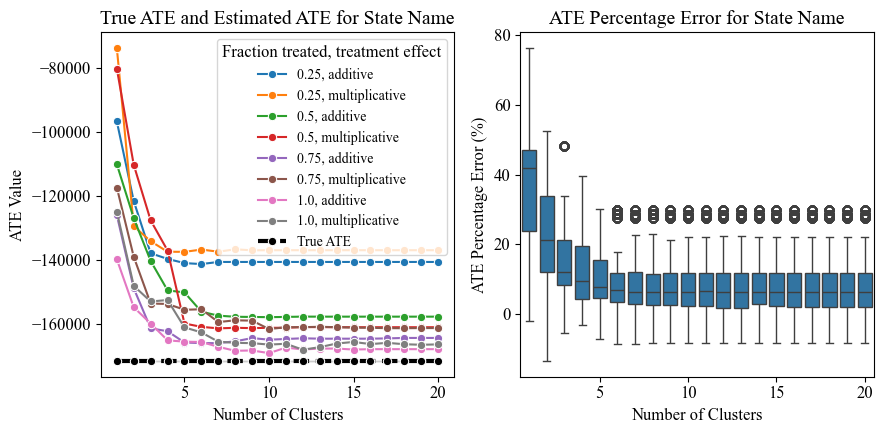

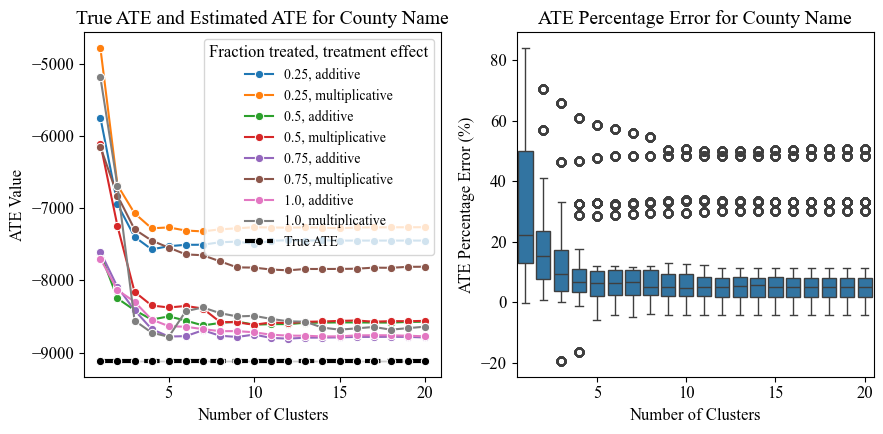

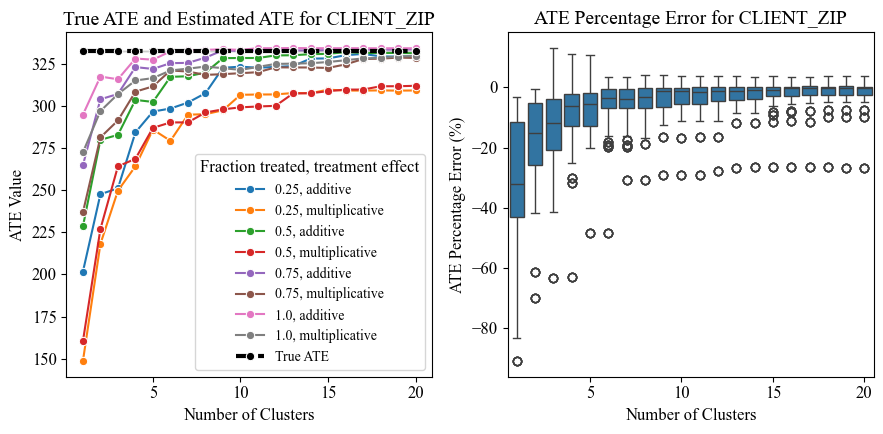

In [12]:
# Averaged over various instances, and leaving out the ones with less than 15% treated

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your folder containing the CSV files
folder_path = 'results'

# Initialize an empty dataframe to hold all the data
combined_df = pd.DataFrame()

# Loop through each CSV file in the folder and concatenate the data
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

# Filter the dataframe to include only methods that start with 'PaCE'
pace_df = combined_df[combined_df['Method'].str.startswith('PaCE')]
pace_df = pace_df[pace_df['Fraction Treated'] >= 0.15]

# Calculate percentage error (not absolute) for ATE (percentage error from True ATE)
pace_df['ATE_perc_error'] = (pace_df['Estimated ATE'] - pace_df['True ATE']) / abs(pace_df['True ATE']) * 100

# Extract the X value from 'PaCE_X' method names
pace_df['PaCE_X'] = pace_df['Method'].str.extract(r'PaCE_(\d+)').astype(int)

# Limit to PaCE_X values up to 20
pace_df = pace_df[pace_df['PaCE_X'] <= 20]

# Get the unique unit types
unique_units = pace_df['Unit'].unique()

# Iterate over each unique unit type and generate plots
for unit in unique_units:
    # Filter the dataframe for the current unit type
    unit_df = pace_df[pace_df['Unit'] == unit]

    plt.rcParams.update({
        'font.family': 'serif',  # Use serif family fonts
        'font.serif': 'Times New Roman',  # Use Times New Roman
        'font.size': 12,  # Set a slightly larger font size
        'axes.titlesize': 14,  # Set a larger title size
        'axes.labelsize': 12,  # Set a slightly larger label size
        'legend.fontsize': 10,  # Set a consistent legend font size
    })

    # Create figure and set up side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))

    # --------- First subplot: Line plot (True ATE vs Estimated ATE) ---------
    # Group by PaCE_X, Fraction Treated, and Treatment Effect Function, calculate mean ATE
    averaged_df = unit_df.groupby(
        ['PaCE_X', 'Fraction Treated', 'Treatment Effect Function']
    ).agg({'Estimated ATE': 'mean', 'True ATE': 'mean'}).reset_index()

    # Create a column for parameter combination label without Adaptive Treatment, and replace underscores with spaces
    averaged_df['Parameter Combination'] = (
        averaged_df['Fraction Treated'].astype(str) + ', ' +
        averaged_df['Treatment Effect Function'].astype(str)
    )

    # Prepare data for plotting (melt for True ATE and Estimated ATE)
    plot_melted = pd.melt(averaged_df, 
                          id_vars=['PaCE_X', 'Parameter Combination'], 
                          value_vars=['Estimated ATE', 'True ATE'], 
                          var_name='ATE Type', value_name='ATE Value')

    # Plot the Estimated ATE for each combination (line plot)
    estimated_ate_data = plot_melted[plot_melted['ATE Type'] == 'Estimated ATE']
    sns.lineplot(x='PaCE_X', y='ATE Value', hue='Parameter Combination', 
                 data=estimated_ate_data, linewidth=1.5, marker='o', ax=axes[0])

    # Plot True ATE last to ensure it's on top
    true_ate_data = plot_melted[plot_melted['ATE Type'] == 'True ATE']
    sns.lineplot(x='PaCE_X', y='ATE Value', data=true_ate_data, 
                 color='black', linewidth=3, label='True ATE', linestyle='--', marker='o', ax=axes[0])

    # Customize the plot
    axes[0].set_title(f'True ATE and Estimated ATE for {unit}', fontsize=14)
    axes[0].set_xlabel('Number of Clusters', fontsize=12)
    axes[0].set_ylabel('ATE Value', fontsize=12)
    axes[0].legend(title='Fraction treated, treatment effect', loc='best')  # Move legend inside the graph

    # --------- Second subplot: Boxplot (ATE Percentage Error) ---------
    # Create the boxplot for the ATE percentage error
    sns.boxplot(x='PaCE_X', y='ATE_perc_error', data=unit_df, ax=axes[1])

    # Customize the boxplot
    axes[1].set_title(f'ATE Percentage Error for {unit}', fontsize=14)
    axes[1].set_xlabel('Number of Clusters', fontsize=12)
    axes[1].set_ylabel('ATE Percentage Error (%)', fontsize=12)
    axes[1].set_xticks(range(4, 20, 5))

    # Adjust layout to ensure everything fits
    plt.tight_layout()

    # Save the plot as a PDF for each unit type
    fig.savefig(f'PaCE_True_vs_Estimated_and_Boxplot_{unit}.pdf', format='pdf')

    # Show the plots (optional if running in a notebook)
    plt.show()


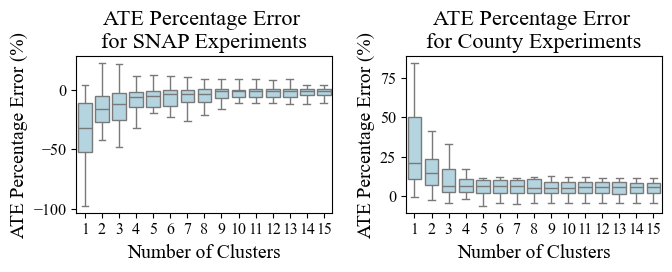

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your folder containing the CSV files
folder_path = 'results'

# Initialize an empty dataframe to hold all the data
combined_df = pd.DataFrame()

# Loop through each CSV file in the folder and concatenate the data
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

# Filter the dataframe to include only methods that start with 'PaCE'
pace_df = combined_df[combined_df['Method'].str.startswith('PaCE')]
pace_df = pace_df[pace_df['Fraction Treated'] >= 0.10]

# Calculate percentage error (not absolute) for ATE (percentage error from True ATE)
pace_df['ATE_perc_error'] = (pace_df['Estimated ATE'] - pace_df['True ATE']) / abs(pace_df['True ATE']) * 100

# Extract the X value from 'PaCE_X' method names
pace_df['PaCE_X'] = pace_df['Method'].str.extract(r'PaCE_(\d+)').astype(int)

# Limit to PaCE_X values up to 20
pace_df = pace_df[pace_df['PaCE_X'] <= 15]

# Set the specific units you want to compare side by side
units_to_compare = ['CLIENT_ZIP', 'County Name']
unit_names = ['SNAP', 'County']

# Create figure and set up side-by-side subplots
plt.rcParams.update({
    'font.family': 'serif',  # Use serif family fonts
    'font.serif': 'Times New Roman',  # Use Times New Roman
    'font.size': 16,  # Increase the overall font size
    'axes.titlesize': 18,  # Set a larger title size
    'axes.labelsize': 16,  # Set a larger label size
    'legend.fontsize': 14,  # Increase legend font size
    'xtick.labelsize': 11.5,  # Increase x-axis tick label size
    'ytick.labelsize': 11.5,  # Increase y-axis tick label size
})

# Define a single color for the boxplots (e.g., light blue)
boxplot_color = '#ADD8E6'

fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Iterate over each unit to plot side-by-side boxplots
for i, unit in enumerate(units_to_compare):
    # Filter the dataframe for the current unit type
    unit_df = pace_df[pace_df['Unit'] == unit]

    # Create the boxplot for the ATE percentage error with the same color for both plots
    sns.boxplot(x='PaCE_X', y='ATE_perc_error', data=unit_df, ax=axes[i], color=boxplot_color, showfliers=False)

    # Customize the boxplot
    axes[i].set_title(f'ATE Percentage Error \nfor {unit_names[i]} Experiments', fontsize=16)
    axes[i].set_xlabel('Number of Clusters', fontsize=14)
    axes[i].set_ylabel('ATE Percentage Error (%)', fontsize=14)

# Adjust layout to ensure everything fits
plt.tight_layout()

# Save the plot as a PDF
fig.savefig('PaCE_True_vs_Estimated_Boxplot_Comparison_SameColor.pdf', format='pdf')

# Show the plots (optional if running in a notebook)
plt.show()


## Analyzing the performance of various methods for HTE estimation


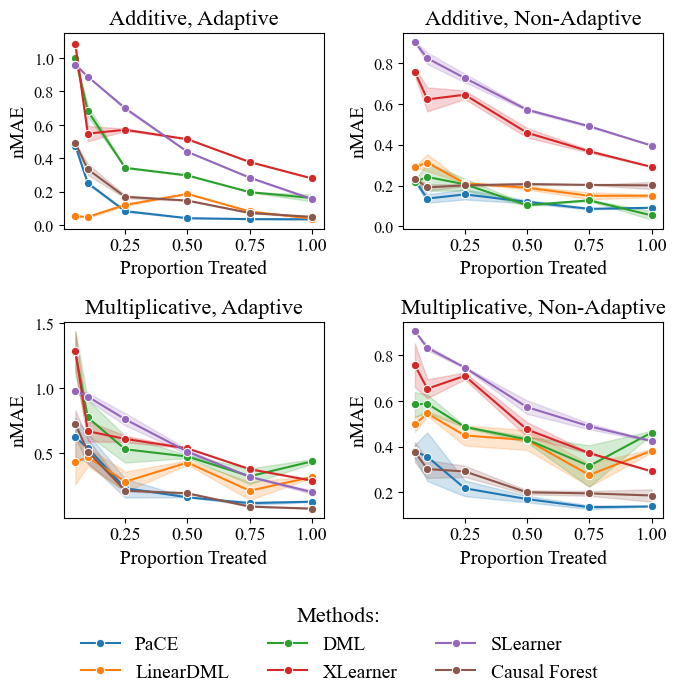

In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib import font_manager


# Path to your folder containing the CSV files
folder_path = 'results'

# Initialize an empty dataframe to hold all the data
combined_df = pd.DataFrame()

# Loop through each CSV file in the folder and concatenate the data
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

snap_df = combined_df[combined_df['Unit'] == 'CLIENT_ZIP']

# Function to filter out unwanted PaCE_X values
def filter_method(method):
    # If it's not of the form PaCE_X, keep it
    if not re.match(r'PaCE_\d+', method): return True
    # If it's PaCE_X and X == 40, rename to PaCE and keep it
    if method == 'PaCE_40': return True
    # Otherwise, don't keep it
    return False

# Apply the filter to the dataframe
snap_df = snap_df[snap_df['Method'].apply(filter_method)]

# Rename 'PaCE_40' to 'PaCE'
snap_df['Method'] = snap_df['Method'].replace('PaCE_40', 'PaCE')
snap_df['Method'] = snap_df['Method'].replace('Causal Forest (R)', 'Causal Forest')

# Group by Method and calculate the mean nMAE for each method
method_nmae_df = snap_df.groupby('Method')['NMAE'].mean().reset_index()

# Sort by nMAE to get the 5 best methods (lowest nMAE)
top_5_methods = method_nmae_df.sort_values(by='NMAE').head(6)['Method'].tolist()

# Filter the dataframe to include only the top 5 methods
top_methods_df = snap_df[snap_df['Method'].isin(top_5_methods)]

# Define a function to plot nMAE vs Proportion Treated for each case
def plot_nmae_vs_fraction(df, treatment_type, effect_type, ax):
    sns.lineplot(
        x='Fraction Treated',
        y='NMAE',
        hue='Method',
        data=df[(df['Adaptive Treatment'] == treatment_type) & 
                (df['Treatment Effect Function'] == effect_type)],
        marker='o',
        ax=ax
    )


    ax.set_title(f'{effect_type.capitalize()}, {"Adaptive" if treatment_type == True else "Non-Adaptive"}')
    ax.set_xlabel('Proportion Treated')
    ax.set_ylabel('nMAE')
    ax.set_xticks(np.arange(0.25, 1.01, 0.25))  # Ticks from 0 to 1 with 0.25 intervals
    ax.legend(title='Method')

plt.rcParams.update({
    'font.family': 'serif',  # Use serif family fonts
    'font.serif': 'Times New Roman',  # Use Times New Roman
    'font.size': 14,  # Set a slightly larger font size
    'axes.titlesize': 16,  # Set a larger title size
    'axes.labelsize': 14,  # Set a slightly larger label size
    'legend.fontsize': 14,  # Set a consistent legend font size
    'xtick.labelsize': 13,  # Increase x-axis tick label size
})

# Create a figure with subplots for each combination
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

# Plot for additive and multiplicative treatment effects for both adaptive and non-adaptive cases
plot_nmae_vs_fraction(top_methods_df, treatment_type=True, effect_type='additive', ax=axes[0, 0])
plot_nmae_vs_fraction(top_methods_df, treatment_type=False, effect_type='additive', ax=axes[0, 1])
plot_nmae_vs_fraction(top_methods_df, treatment_type=True, effect_type='multiplicative', ax=axes[1, 0])
plot_nmae_vs_fraction(top_methods_df, treatment_type=False, effect_type='multiplicative', ax=axes[1, 1])

# Add one single legend for the entire figure, placing it just above the bottom with a larger title
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), 
           title='Methods:', frameon=False, ncol=3, title_fontsize=16)  # Adjust the title font size here



# Remove individual legends
for ax in axes.flatten():
    ax.get_legend().remove()

# Adjust layout to ensure everything fits
plt.tight_layout()

# Save the plot as a PDF (uncomment if needed)
fig.savefig('Top_5_Methods_nMAE_vs_Proportion_Treated.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


## Analyzing the runtime of various methods

In [15]:
combined_df.groupby(['Method', 'Unit'])['Time Taken'].mean().unstack()

Unit,CLIENT_ZIP,County Name,State Name
Method,,,
Causal Forest (R),29.147509,13.049178,1.718983
CausalForestDML,24.519006,19.347555,5.470121
DC-PR,2.621745,1.671022,0.226861
DID,0.136097,0.061602,0.022907
DML,21.957058,20.468379,2.870808
DRLearner,115.747292,101.166814,10.531147
DomainAdaptationLearner,57.452103,55.446937,4.421740
ForestDRLearner,45.051057,34.440625,8.735769
KRLS (R),NaN,NaN,57.061506
